# Tightness-Adjusted Flows


In [1]:
import matplotlib.pyplot as plt
from pathlib import Path
from matplotlib.collections import LineCollection
import matplotlib as mpl
import numpy as np
from scipy import optimize as opt
from scipy import integrate as intg
from scipy.optimize import least_squares
from scipy.stats import beta
from scipy.stats import cumfreq, beta

%matplotlib inline
plt.style.use('../notebook.mplstyle')

## Exogenous Parameters


In [2]:
# Setting exogenous parameters
def reset_exog_params():
    global Bm, Bw, bm_vals, bw_vals, δ, Um, Uw, Fm, Fw, λm, λw  
    Bm = 10
    Bw = 10
    bm_vals = range(1,Bm+1) 
    bw_vals = range(1,Bw+1)
    
    δ = 0.97
    Um = lambda θ : θ 
    Uw = lambda θ : θ
    Fm = beta(3,3)
    Fw = beta(3,3)
    λm = 20
    λw = 10

## Two-Sided Search Equilibrium Conditions 


In [3]:
# Optimality conditions
def SSE(x): 
    # Endogenous Variables 
    μ = x[:Bm] 
    ω = x[Bm:Bm+Bw]  
    print('mu:', μ)
    print('omega:', ω)

    Pm = x[Bm+Bw:2*Bm+Bw]
    Pw = x[2*Bm+Bw:2*Bm+2*Bw] 
    
    print('Pm:', Pm)
    print('Pw:', Pw)

    Nm = x[2*Bm+2*Bw] 
    Nw = x[2*Bm+2*Bw+1] 
    print('Nm', Nm)
    print('Nw', Nw)
    print('')
    
    τm = min(Nw/Nm, 1)
    τw = τm * (Nm/Nw) 
    αm = (τm*δ)/(1-δ*(1-τm))
    αw = (τw*δ)/(1-δ*(1-τw)) 

    # Initialising system of equilibrium equations
    E = np.empty(2*Bm + 2*Bw + 2) 

    # Initial condition for men 
    E[0] = (Um(μ[0]) 
            - αm * Um(μ[0]) * Fw.cdf(μ[0]) 
            - αm * intg.quad(lambda t: Um(t) * Fw.pdf(t), μ[0], 1)[0]) 
    
    # Intertemporal optimality conditions for men
    for b in range(1, Bm):
        E[b] = (Um(μ[b]) 
                - αm * Um(μ[b]) * Fw.cdf(μ[b]) 
                - αm * Um(μ[b-1])*(1-Fw.cdf(μ[b-1])) 
                - αm * intg.quad(lambda t : Um(t) * Fw.pdf(t), μ[b], μ[b-1])[0])

    E[Bm] = (Uw(ω[0]) 
            - αw * Uw(ω[0]) * Fm.cdf(ω[0]) 
            - αw * intg.quad(lambda t: Uw(t) * Fm.pdf(t), ω[0], 1)[0])

    # Intertemporal optimality conditions for women
    for b in range(1, Bw):
        E[Bm+b] = (Uw(ω[b]) 
                - αw * Uw(ω[b]) * Fm.cdf(ω[b]) 
                - αw * Uw(ω[b-1])*(1-Fm.cdf(ω[b-1])) 
                - αw * intg.quad(lambda t : Uw(t) * Fm.pdf(t), ω[b], ω[b-1])[0]) 
                
    # Platform flow men
    E[Bm+Bw] = λm - (1-δ)*Nm - Nm*Pm[0]*δ*τm*(1-Fw.cdf(μ[0]))

    for b in range(0, Bm-1):
       E[Bm+Bw+b+1] = (Nm*Pm[b+1]*δ*τm*(1-Fw.cdf(μ[b+1]))
                    - Nm*Pm[b]*(1-δ) - Nm*Pm[b]*δ*τm*(1-Fw.cdf(μ[b])))

    E[2*Bm+Bw] = λm - Nm*Pm[Bm-1]*(1-δ) - Nm*Pm[Bm-1]*δ*τm*(1-Fw.cdf(μ[Bm-1]))

    # Platform flow women
    E[2*Bm+Bw+1] = λw - (1-δ)*Nw - Nw*Pw[0]*δ*τw*(1-Fm.cdf(ω[0]))  

    for b in range(0, Bw-1):
       E[2*Bm+Bw+2+b] = (Nw*Pw[b+1]*δ*τw*(1-Fm.cdf(ω[b+1]))
                      - Nw*Pw[b]*(1-δ) - Nw*Pw[b]*δ*τw*(1-Fm.cdf(ω[b])))

    E[2*Bm+2*Bw+1] = λw - Nw*Pw[Bw-1]*(1-δ) - Nw*Pw[Bw-1]*δ*τw*(1-Fm.cdf(ω[Bw-1])) 

    return E 

# MODEL TEST

In [4]:
reset_exog_params()

x = np.array([0.66366994, 0.59515949, 0.54890106, 0.51301625, 0.4833236, 0.45781311,
0.43534878, 0.41521996, 0.3969497, 0.38020096, 0.66366994, 0.59515949, 0.54890106, 0.51301625, 0.4833236, 0.45781311,
 0.43534878, 0.41521996, 0.3969497, 0.38020096, 0.15725993, 0.11837237, 0.10328159, 0.09551076, 0.09106793, 0.08846318,
 0.08700424, 0.0863228, 0.08620388, 0.0865133, 0.15725993, 0.11837237, 0.10328159, 0.09551076, 0.09106793, 0.08846318,
 0.08700424, 0.0863228, 0.08620388, 0.0865133, 159.50166568356278, 159.50166568356278])
print(np.around(SSE(x)))
print(np.sum((SSE(x))**2))

mu: [0.66366994 0.59515949 0.54890106 0.51301625 0.4833236  0.45781311
 0.43534878 0.41521996 0.3969497  0.38020096]
omega: [0.66366994 0.59515949 0.54890106 0.51301625 0.4833236  0.45781311
 0.43534878 0.41521996 0.3969497  0.38020096]
Pm: [0.15725993 0.11837237 0.10328159 0.09551076 0.09106793 0.08846318
 0.08700424 0.0863228  0.08620388 0.0865133 ]
Pw: [0.15725993 0.11837237 0.10328159 0.09551076 0.09106793 0.08846318
 0.08700424 0.0863228  0.08620388 0.0865133 ]
Nm 159.50166568356278
Nw 159.50166568356278

[-0.  0. -0.  0.  0.  0. -0.  0. -0.  0. -0.  0. -0.  0.  0.  0. -0.  0.
 -0.  0. 10. -0. -0. -0. -0.  0. -0. -0.  0. -0. 10. -0. -0. -0. -0. -0.
  0. -0. -0.  0. -0.  0.]
mu: [0.66366994 0.59515949 0.54890106 0.51301625 0.4833236  0.45781311
 0.43534878 0.41521996 0.3969497  0.38020096]
omega: [0.66366994 0.59515949 0.54890106 0.51301625 0.4833236  0.45781311
 0.43534878 0.41521996 0.3969497  0.38020096]
Pm: [0.15725993 0.11837237 0.10328159 0.09551076 0.09106793 0.08846318
 0.0

## Solving For Steady State Equilibria 

In [5]:
reset_exog_params()
μ_test = np.random.rand(Bm) 
ω_test = np.random.rand(Bw) 

Pm_test = np.random.rand(Bm)
Pw_test = np.random.rand(Bw) 

N_test = np.array([λm*(Bm+1), λw*(Bw+1)])

print('μ0: ', μ_test)
print('ω0: ', ω_test)
print('')

x_start = np.concatenate((μ_test, ω_test, Pm_test, Pw_test, N_test), axis=None) 
x_max = np.concatenate((np.ones(2*Bm+2*Bw), np.ones(2)*np.inf), axis=None)
print('Upper Bound', x_max)
solution = opt.root(SSE, x_start) 

μ0:  [0.03826852 0.79187139 0.14412499 0.53229608 0.41343763 0.94014651
 0.46243505 0.00933224 0.69092784 0.170172  ]
ω0:  [0.43576517 0.30058097 0.54826771 0.51290724 0.02398133 0.84407306
 0.88182825 0.35027171 0.58803715 0.02786501]

Upper Bound [ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1. inf inf]
mu: [0.03826852 0.79187139 0.14412499 0.53229608 0.41343763 0.94014651
 0.46243505 0.00933224 0.69092784 0.170172  ]
omega: [0.43576517 0.30058097 0.54826771 0.51290724 0.02398133 0.84407306
 0.88182825 0.35027171 0.58803715 0.02786501]
Pm: [0.31268021 0.84909704 0.27397783 0.21360231 0.00130577 0.13137226
 0.43403278 0.70564968 0.96762271 0.89467541]
Pw: [0.67201012 0.03458267 0.93918344 0.27115848 0.12434403 0.78732554
 0.09960595 0.80463943 0.41710101 0.22686533]
Nm 220.0
Nw 110.0

mu: [0.03826852 0.79187139 0.14412499 0.53229608 0.41343763 0.94014651
 0.46243505 0.0093

In [9]:
μ_star = solution.x[:Bm]
ω_star = solution.x[Bm:Bm+Bw]
print('μ* ', μ_star) 
print('ω* ', ω_star) 
print('Loss:', np.sum(SSE(solution.x)**2)) 
print('')

Pm = solution.x[Bm+Bw:2*Bm+Bw]
Pw = solution.x[2*Bm+Bw:2*Bm+2*Bw] 

Nm = solution.x[2*Bm+2*Bw] 
Nw = solution.x[2*Bm+2*Bw+1] 
print('Masses: ', round(Nm,3), round(Nw,3))
print('PMF check:', round(sum(Pm),3), round(sum(Pw),3))
print('')

τm = min(Nw/Nm, 1)
τw = τm * (Nm/Nw) 
αm = (τm*δ)/(1-δ*(1-τm))
αw = (τw*δ)/(1-δ*(1-τw)) 
print('Tightness: ', round(τm,3), round(τw,3))
print('Alphas: ', round(αm,3), round(αw,3)) 
print('')

ρm = sum([(1 - Fm.cdf(ω_star[b]))*Pw[b] for b in range(Bw)])
ρw = sum([(1 - Fw.cdf(μ_star[b]))*Pm[b] for b in range(Bm)])
print('Average Pr(right-swipe): ', round(ρm, 2), round(ρw, 2))

μ*  [0.56258451 0.47202629 0.41132631 0.36474793 0.32672713 0.29458043
 0.26678558 0.24238559 0.22073373 0.2013686 ]
ω*  [0.66366994 0.59515949 0.54890106 0.51301625 0.4833236  0.45781311
 0.43534878 0.41521996 0.3969497  0.38020096]

Masses:  462.803 159.502
PMF check: 1.0 1.0

Tightness:  0.345 1.0
Alphas:  0.918 0.97

Average Pr(right-swipe):  0.49 0.77


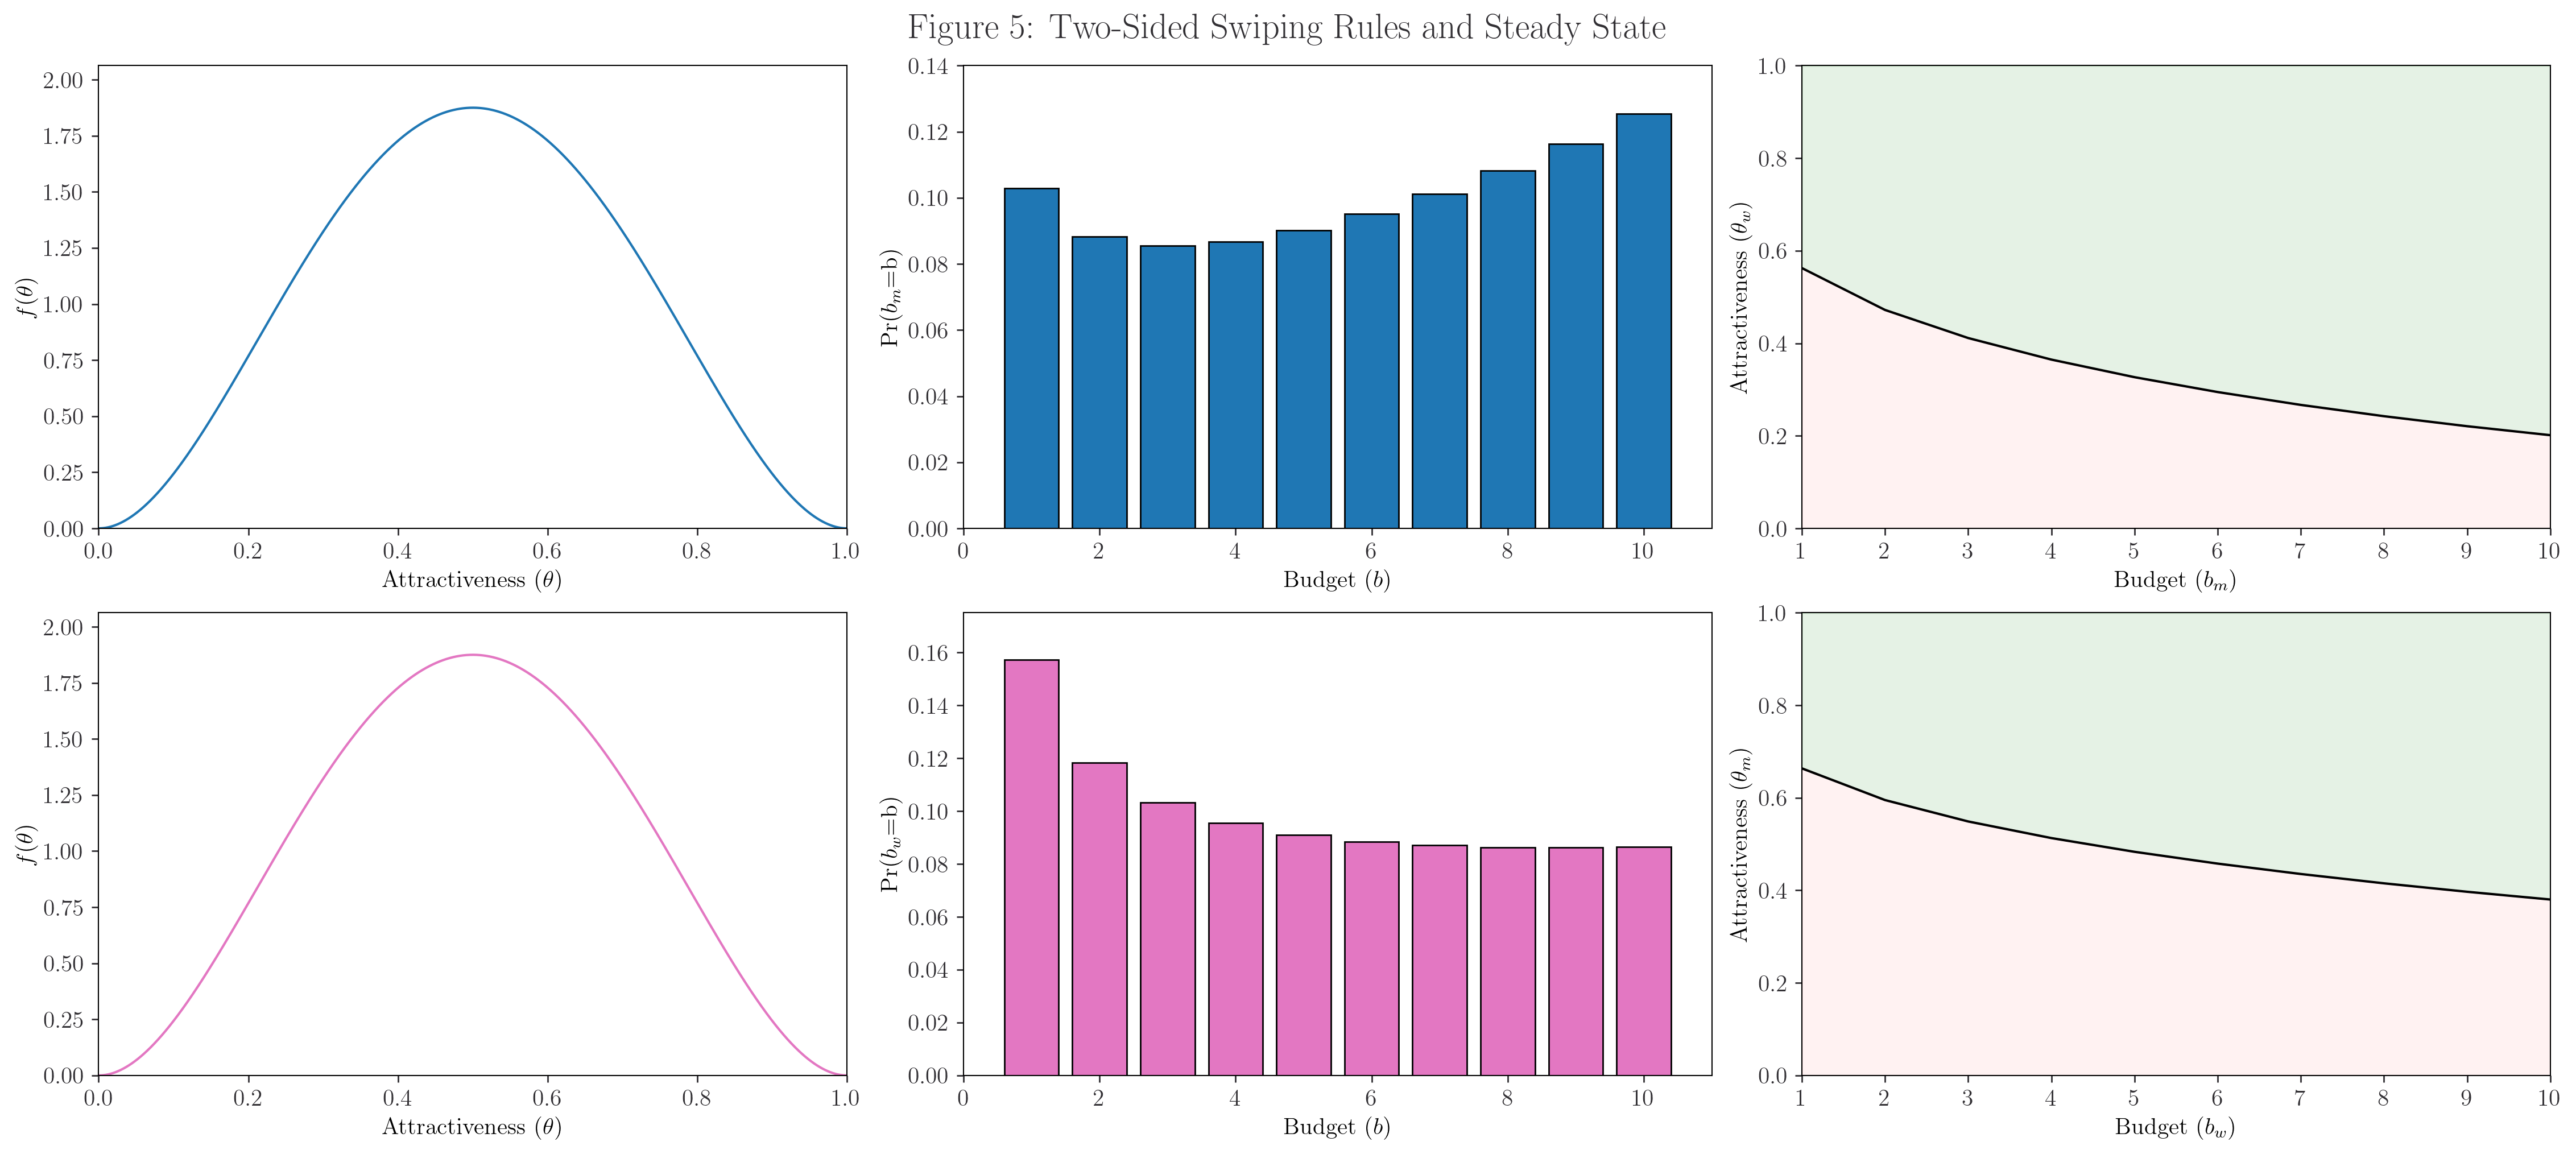

In [8]:
# Plotting Marginal PDFs
fig, axs = plt.subplots(2,3,figsize=(18, 8), constrained_layout=True)
x = np.linspace(0, 1, 5000)

axs[0,0].set_xlim(0,1)
axs[0,0].set_ylim(0,1.1*max(Fm.pdf(x)))
axs[0,0].plot(x, Fm.pdf(x), color='tab:blue') 

axs[1,0].set_xlim(0,1)
axs[1,0].set_ylim(0,1.1*max(Fw.pdf(x)))
axs[1,0].plot(x, Fw.pdf(x), color='tab:pink')

# Plotting Marginal PMFs 
axs[0,1].set_xlim(0,Bm+1)
axs[0,1].bar(bm_vals, Pm, color='tab:blue') 

axs[1,1].set_xlim(0,Bw+1)
axs[1,1].bar(bw_vals, Pw, color='tab:pink') 

axs[0,1].set(xlabel=r'Budget ($b$)', ylabel=r'Pr($b_m$=b)') 
axs[1,1].set(xlabel=r'Budget ($b$)', ylabel=r'Pr($b_w$=b)') 

#axs[0,0].set_title('Men',loc='center')
axs[0,0].set(xlabel=r'Attractiveness ($\theta$)', ylabel=r'$f(\theta)$')

#axs[0,1].set_title('Women',loc='center')
axs[1,0].set(xlabel=r'Attractiveness ($\theta$)', ylabel=r'$f(\theta)$')


for i in range(2):
    B = Bm if i==0 else Bw
    b_vals = bm_vals if i==0 else bw_vals
    θ_vals = μ_star if i==0 else ω_star
    
    axs[i,2].set_xlim(1,B)
    axs[i,2].set_ylim(0,1)
    axs[i,2].plot(b_vals, θ_vals, color='k')
    axs[i,2].fill_between(b_vals, 0, θ_vals, color='red', alpha=0.05)
    axs[i,2].fill_between(b_vals, θ_vals, 1, color='green', alpha=0.1)

axs[0,2].set(xlabel=r'Budget ($b_m$)', ylabel=r'Attractiveness ($\theta_w$)')
axs[1,2].set(xlabel=r'Budget ($b_w$)', ylabel=r'Attractiveness ($\theta_m$)')
fig.suptitle('Figure 5: Two-Sided Swiping Rules and Steady State ')
plt.savefig('../../figures/mkt-cs.png')
plt.show()